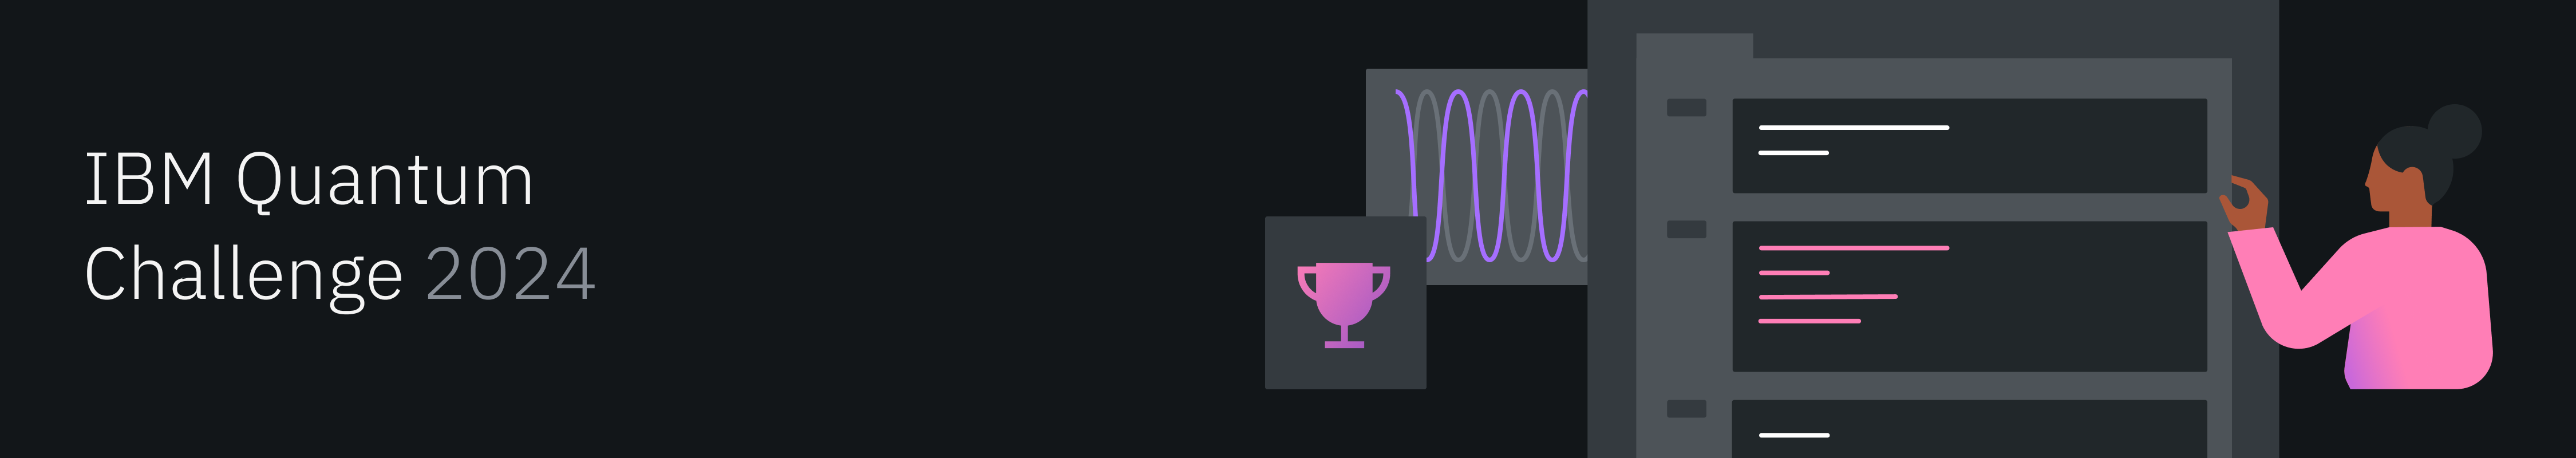

# Bonus Lab: Scaling to 50 qubits!


Ready to elevate your quantum computing skills? Your next challenge is to scale up the results from Lab 4 to 50 qubits! As the system size grows, we'll need to optimize our Variational Quantum Classifier (VQC) and reduce its depth. This is crucial because the mapping used for the `GHZ` state scales linearly with the number of qubits. We’ll adapt our quantum circuits to fit this larger scale and provide you with pre-trained optimal parameters. Your task is to test the functionality of the `VQC` in this extended qubit range.

**Why is this important?** Simulating more than 50 qubits is a significant feat in the quantum world and not many have ventured into running circuits of this size—it's a unique opportunity to push the boundaries of what's achievable in quantum simulations.

Please note, **this is a bonus lab** intended only for those who have successfully completed Lab 4, as it builds directly on the foundations and solutions you've developed. Dive into this advanced challenge and join the elite group experimenting at this level in quantum computing!

## Guideline

* [Step 1: Find a way to efficiently create GHZ states on 50 qubits](#Step-1:-Find-a-way-to-efficiently-create-GHZ-states-on-50-qubits)
* [Step 2: Adapt the `RealAmplitudes` ansatz to the new mapping](#Step-2:-Adapt-the-RealAmplitudes-ansatz-to-the-new-mapping)
* [Step 3: Check the optimal parameters using the `AerSimulator`](#Step-3:-Check-the-optimal-parameters-using-the-AerSimulator)
* [**Final step:** Testing a **50 qubit VQC on a quantum device (!)**](#Final-step:-Testing-a-50-qubit-VQC-on-a-quantum-device-(!))

Let's start by importing all the libraries that you will be needing in this Lab:

# Imports

In [ ]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -U

zsh:1: no matches found: qiskit[visualization]==1.0.2


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /private/var/folders/nv/vf2cm8nn6jjd3h0txmrbrbvh0000gn/T/pip-req-build-1arjgq6_
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /private/var/folders/nv/vf2cm8nn6jjd3h0txmrbrbvh0000gn/T/pip-req-build-1arjgq6_
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1742268fcb91b9f53c7f9ca83d3511adf200f3a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependenci

Now, let's run our imports

In [ ]:
# Import all in one cell

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_distribution
from qiskit.circuit import ParameterVector

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Save API Token, if needed

%set_env QXToken=YOUR_API_TOKEN

# Make sure there is no space between the equal sign
# and the beginning of your token

In [ ]:
# qc-grader should be 0.18.13 (or higher)
import qc_grader

qc_grader.__version__

'0.18.13'

In [ ]:
from qc_grader.challenges.iqc_2024 import grade_lab_bonus_ex1, grade_lab_bonus_ex2, grade_lab_bonus_ex3

## Step 1: Find a way to efficiently create GHZ states on 50 qubits

Start by recovering your amplitude embedding function from Lab 4:

In [ ]:
def old_amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
        return qc
    
    qc = QuantumCircuit(num_qubits)    
    
    ### Write your code below here ###
    
    # For bird index <= 4, we use the GHZ state as the initial state
    if bird_index <=4:
        qc = generate_GHZ(qc)
    
    elif bird_index >=10:
        raise ValueError("Bird index should be less than 10")
    
    # Here we add the bit flip to the binary position of the bird index!
    for qubit, character in enumerate(reversed('{0:b}'.format(bird_index))):
        if character == '1':
            qc.x(qubit)
    
    ### Don't change any code past this line ###
    return qc

The generation of the GHZ state in the previous `old_amplitude_embedding` function scales linearly with the number of qubits. You can check it using the following cells from Lab 4:

In [ ]:
num_qubits = 50

# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 # You can check different birds by changing the index
qc = old_amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth of two-qubit gates:  49


In [ ]:
# Testing the coupling map is correct:
coupling_map = backend.coupling_map
edges = list(coupling_map.get_edges())
print(edges)

[(49, 55), (73, 66), (83, 92), (99, 100), (122, 111), (16, 26), (22, 15), (30, 31), (33, 39), (34, 43), (47, 35), (53, 60), (54, 64), (77, 71), (81, 72), (87, 93), (98, 91), (104, 111), (4, 5), (8, 16), (17, 12), (21, 20), (28, 35), (34, 24), (40, 41), (50, 51), (54, 45), (62, 61), (68, 69), (71, 58), (73, 85), (80, 79), (89, 88), (96, 109), (102, 92), (118, 110), (122, 121), (125, 126), (0, 14), (4, 3), (8, 9), (12, 13), (23, 24), (27, 28), (31, 32), (33, 20), (42, 41), (46, 45), (50, 49), (52, 37), (59, 58), (65, 66), (70, 69), (72, 62), (75, 90), (79, 78), (84, 83), (88, 87), (96, 97), (104, 103), (110, 100), (124, 123), (3, 2), (7, 6), (11, 10), (18, 14), (22, 21), (25, 26), (30, 29), (39, 40), (44, 43), (48, 47), (56, 52), (59, 60), (63, 64), (67, 68), (77, 78), (82, 81), (86, 85), (97, 98), (101, 102), (105, 106), (121, 120), (125, 124), (1, 2), (6, 5), (9, 10), (17, 30), (18, 19), (22, 23), (27, 26), (38, 39), (43, 42), (47, 46), (51, 36), (55, 68), (57, 56), (61, 60), (64, 65),

If the two-qubit depth is of the order of 50 it is too large!! 

<a id="step1"></a>
<div class="alert alert-block alert-success">

**Task:** Find a way to efficiently encode the GHZ states in a large circuit and reduce the circuit two-qubit depth to 13 or less. This [blog post](https://dahalegopal27.medium.com/greetings-from-the-ibm-spring-challenge-map-of-127-qubits-ce08817176a7) can serve as inspiration!

> _The underlying concept leverages the symmetry in entangled qubits. Once two qubits are entangled, their symmetrical properties can be utilized to entangle additional qubits. This cascading entanglement process can be very efficient if the quantum system allows for all-to-all connectivity; in such a scenario, creating a GHZ state involving 
$𝑁$ qubits requires only an asymptotic complexity of $(O(\log(N)))$ steps._ 

> _However, in systems with heavy hexagonal (heavy hex) connectivity, the process is less efficient, and requires $(O(\sqrt{N}))$ steps to achieve the same._

</div> 

In [ ]:
# Function to compute the edges of the coupling map that are within the `num_qubits` range:`
def compute_size_50_edges(backend):
    coupling_map = backend.coupling_map
    edges = list(coupling_map.get_edges())

    filtered_edges = []

    for edge in edges:
        if edge[0] < num_qubits and edge[1] < num_qubits:
            filtered_edges.append(edge)
    
    return filtered_edges

In [71]:
def new_amplitude_embedding(num_qubits, bird_index, backend=service.backend("ibm_osaka")):
    """Create efficient amplitude embedding circuit
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
            
    ### Write your code below here ###
    
    # Function to create the two list, that will be iterated to create the GHZ state below:
    def compute_entangled_qubits(starter_qubit):
        entangled_qubits = [starter_qubit]
        non_entangled_qubits = [i for i in range(num_qubits)]
        non_entangled_qubits.remove(starter_qubit)
        
        return entangled_qubits, non_entangled_qubits
    
    
    # Manual algorithm to create GHZ state..
    # First it creates a Hadamard state, and then checking at each iteration the real physical topology connetions
    # it goes one by one, entangling to create the final GHZ state, it works like:
    # --------------------------------------------------------
    # 1) Start with a hadamart gate in a qubit (a central one will be nice)
    # 2) From there, checking the physcial connectivities, do a CNOT, using the central as control, to another in its side (target)
    # 3) Now you can do the same as in 2), but using the both of the above qubits as targets (they have entered the 
    #    list of entangled), and you have another list remaining of unentangled (all 50, exepct those 2)
    # 4) Repeat 3), until your list of entangles is [0, ..., 50] , and the untengaled empty! 
    # --------------------------------------------------------
    # So basically each CNOT you do to an unentagled using an entangled as control, passes, the unentangled to 
    # entangled, and you wanna do that until you have passed all the unentangled list to entangled , while using
    # CNOTS only through the physical connectivities (backend.coupling_map.get_edges())
    def new_GHZ(qc, starter_qubit:int=25, backend=service.backend("ibm_osaka")):
    
        filtered_edges = compute_size_50_edges(backend)
        entangled_qubits, non_entangled_qubits = compute_entangled_qubits(starter_qubit)
        
        qc.h(starter_qubit)
        
        while len(entangled_qubits) < num_qubits:
            for j in entangled_qubits:
                if (non_entangled_qubits[0], j) in filtered_edges or (j, non_entangled_qubits[0]) in filtered_edges:
                    qc.cx(j, non_entangled_qubits[0])
                    
                    entangled_qubits.append(non_entangled_qubits[0])
                    non_entangled_qubits.remove(non_entangled_qubits[0])
                    
                    break
                
                for i in non_entangled_qubits:
                    if (j, i) in filtered_edges or (i, j) in filtered_edges:
                        qc.cx(j, i)
                        
                        entangled_qubits.append(i)
                        non_entangled_qubits.remove(i)
                        
                        break
    
        return qc
    
    
    qc = QuantumCircuit(num_qubits)

    # For bird index <= 4, we use the GHZ state as the initial state
    if bird_index <=4:
        qc = new_GHZ(qc)
    
    elif bird_index >=10:
        raise ValueError("Bird index should be less than 10")
    
    # Here we add the bit flip to the binary position of the bird index!
    for qubit, character in enumerate(reversed('{0:b}'.format(bird_index))):
        if character == '1':
            qc.x(qubit)
    
    ### Don't change any code past this line ###
    return qc

The `matrix_product_state` [MPS](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html) method is more efficient than a full statevector simulation because it reduces the computational and memory demands. While the full statevector simulation requires exponential resources in relation to the number of qubits, MPS uses a tensor-based representation that scales more favorably, particularly in systems with low entanglement. This allows MPS to perform operations faster and with less memory in many scenarios, making it particularly effective for circuits that aren't heavily entangled and are low in depth. 

**You can find more about this in the documentation link [here.](https://qiskit.github.io/qiskit-aer/tutorials/7_matrix_product_state_method.html#id1)**

**You can use the following cell below to check that you are mapping the right states.**


<div class="alert alert-block alert-danger">

**Please note:** Please make sure your `GHZ` is constructed correct using the code block below. Try experimenting with different values of index and ensure you get a `GHZ` state.

</div>

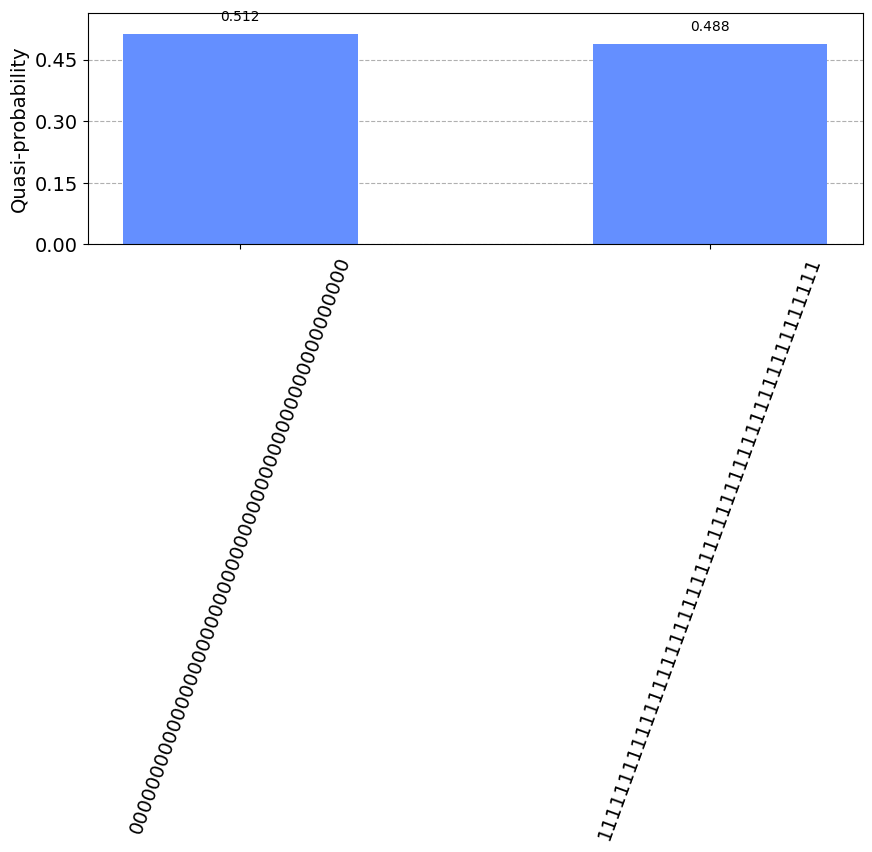

In [ ]:
num_qubits = 50
index = 0 # Change to different values for testing
qc = new_amplitude_embedding(num_qubits, index)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(10, 3))

Depth of two-qubit gates:  11


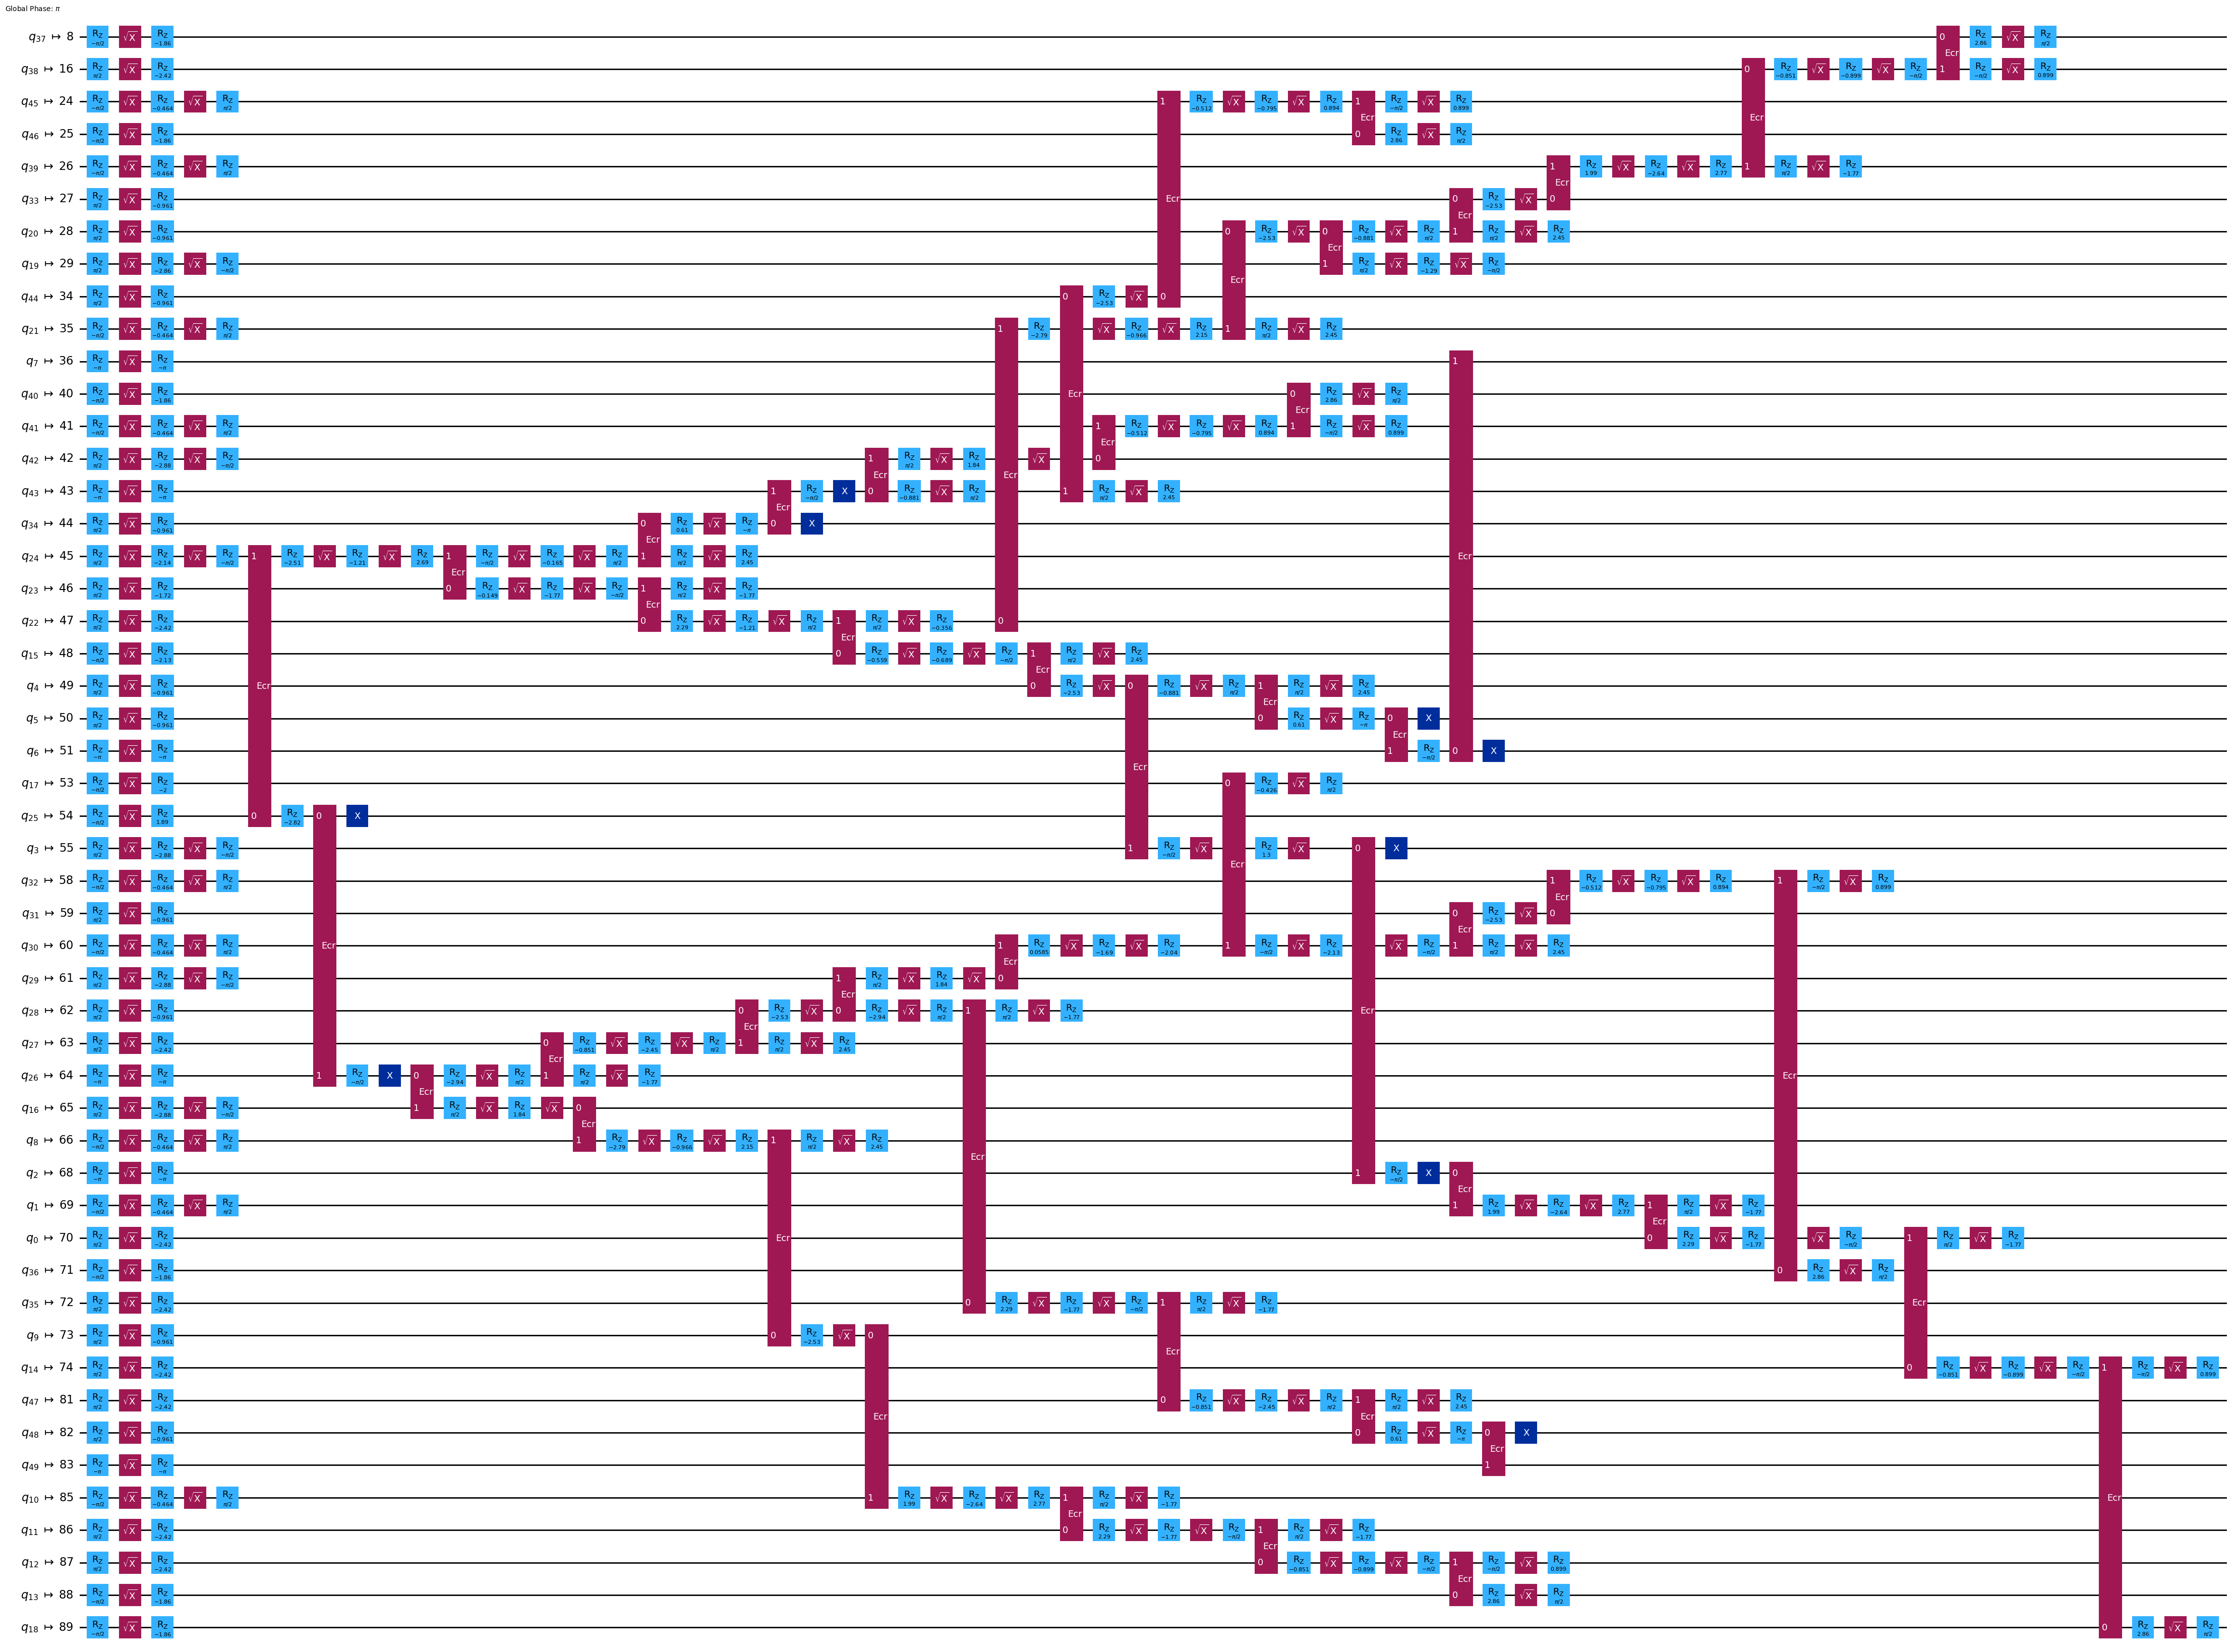

In [ ]:
num_qubits = 50

# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 #You can check different birds by changing the index
qc = new_amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
# Submit your answer using following code
grade_lab_bonus_ex1(new_amplitude_embedding(50,3)) # Expected answer type: QuantumCircuit

Submitting your answer. Please wait...
New amplitude embedding circuit two-qubit depth: 11 < 13 (threshold).
Congratulations! 🎉 Your answer is correct.


## Step 2: Adapt the `RealAmplitudes` ansatz to the new mapping

The previous ansatz needs to be adapted to the new connectiviy, but without increasing the layers. Check that, when transpiling the ansatz with `pairwise` connectivity together with the `new_amplitude_embedding`, the circuit is more than **100 layers(!)**

In [ ]:
def generate_old_ansatz(qubits):
    qc = RealAmplitudes(qubits, reps=1, entanglement='pairwise')
    return qc

num_qubits = 50

# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 # You can check different birds by changing the index
qc = new_amplitude_embedding(num_qubits, index_bird)
ansatz = generate_old_ansatz(num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_qc = pm.run(qc.compose(ansatz))
print('Depth new mapping + old ansatz: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
# transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth new mapping + old ansatz:  79


<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** Change the entanglement structure of the `RealAmplitudes` ansatz so that the total two-qubit depth of the circuit (embedding + ansatz) is reduced to **less than `15` layers**. 

*Hint: Consider the mapping that you have used for the `GHZ` state for the heavy hex lattice and try to entangle the qubits to the neighbouring ones if possible, with only 3 alternating layers.*

</div>  

In [ ]:
def generate_ansatz(num_qubits, backend=service.backend("ibm_osaka")):
    """Generate a `RealAmplitudes` ansatz where all qubits are entangled with each other 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
    
    Returns:
        qc (QuantumCircuit): Quantum circuit with the generated ansatz
    """
    ### Write your code below here ###
    
    
    # Generate the ansatz with all qubits entangled, which are given by the coupling map:
    qc = RealAmplitudes(num_qubits, reps=1, entanglement=compute_size_50_edges(backend), skip_unentangled_qubits=True)

    
    ### Don't change any code past this line ###  
    return qc

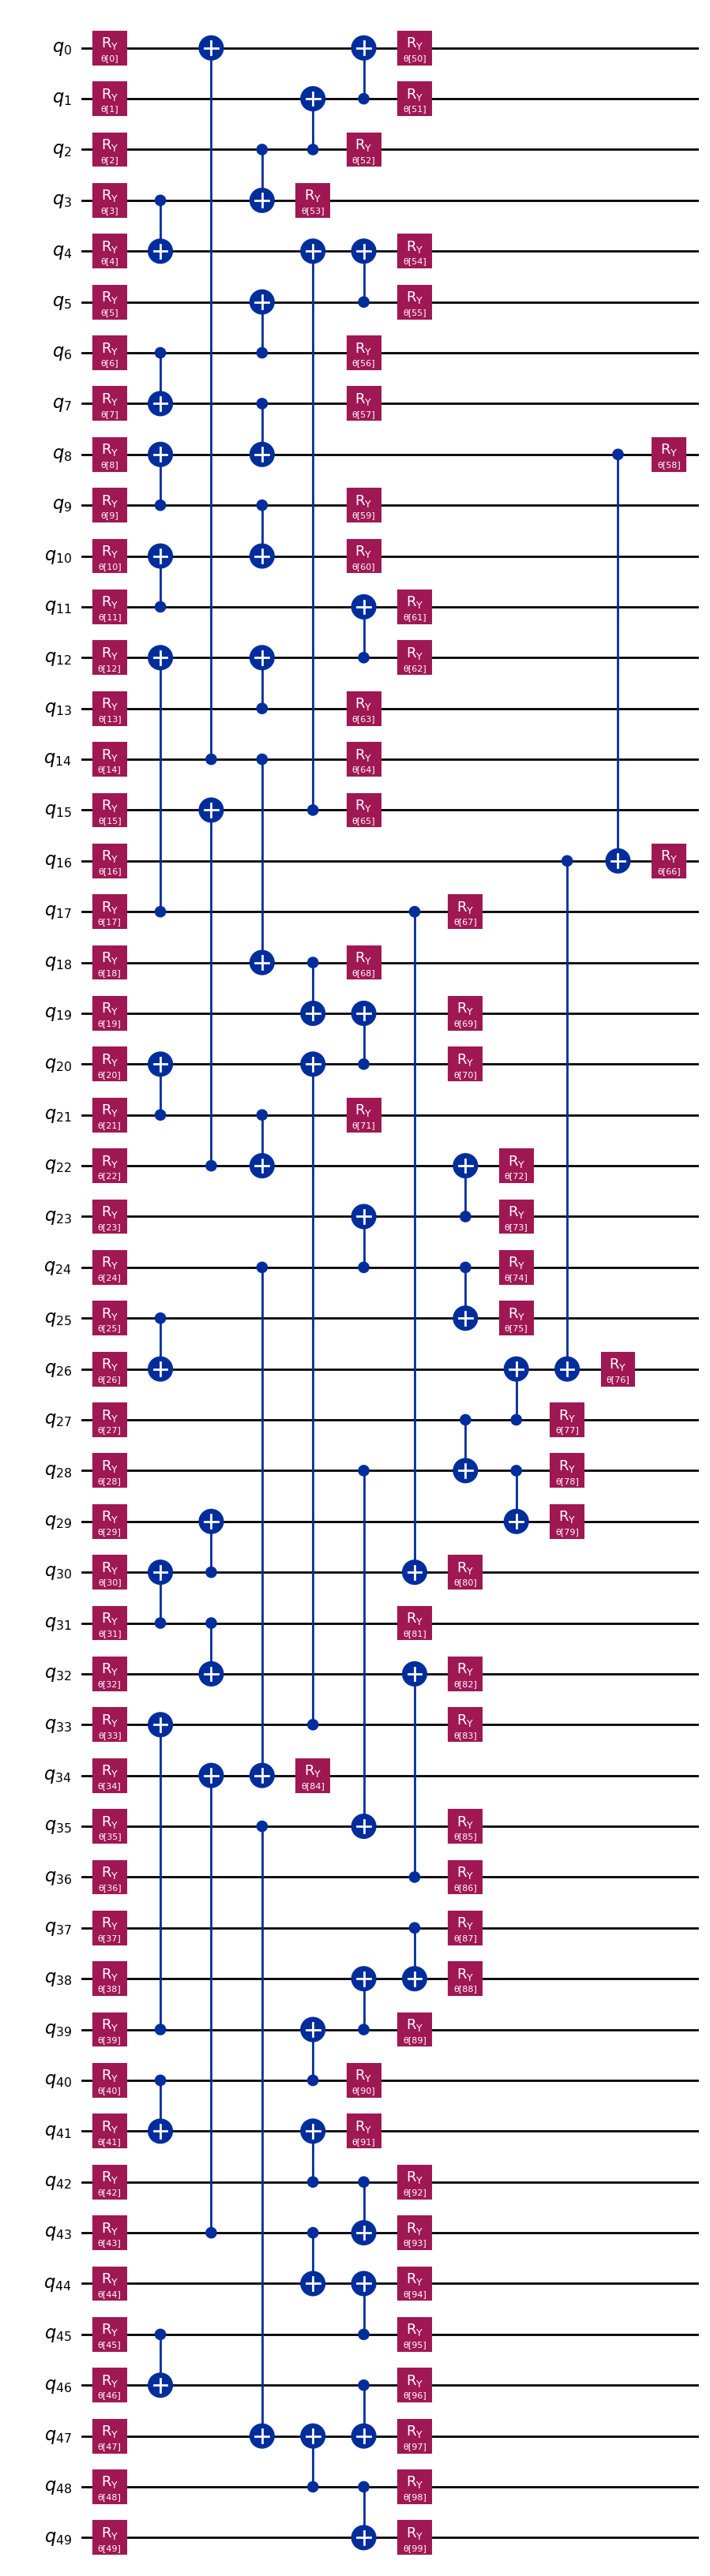

In [ ]:
generate_ansatz(50).decompose().draw(output="mpl", fold=False, idle_wires=False)

In [72]:
# Check that the ansatz has the same CX, that the connection of this list:
print(compute_size_50_edges(backend))

[(16, 26), (22, 15), (30, 31), (33, 39), (34, 43), (47, 35), (4, 5), (8, 16), (17, 12), (21, 20), (28, 35), (34, 24), (40, 41), (0, 14), (4, 3), (8, 9), (12, 13), (23, 24), (27, 28), (31, 32), (33, 20), (42, 41), (46, 45), (3, 2), (7, 6), (11, 10), (18, 14), (22, 21), (25, 26), (30, 29), (39, 40), (44, 43), (48, 47), (1, 2), (6, 5), (9, 10), (17, 30), (18, 19), (22, 23), (27, 26), (38, 39), (43, 42), (47, 46), (1, 0), (8, 7), (11, 12), (15, 4), (19, 20), (25, 24), (28, 29), (32, 36), (37, 38), (44, 45), (49, 48)]


##### Run this cell to check the total two-qubit depth

Depth new mapping + new ansatz:  15


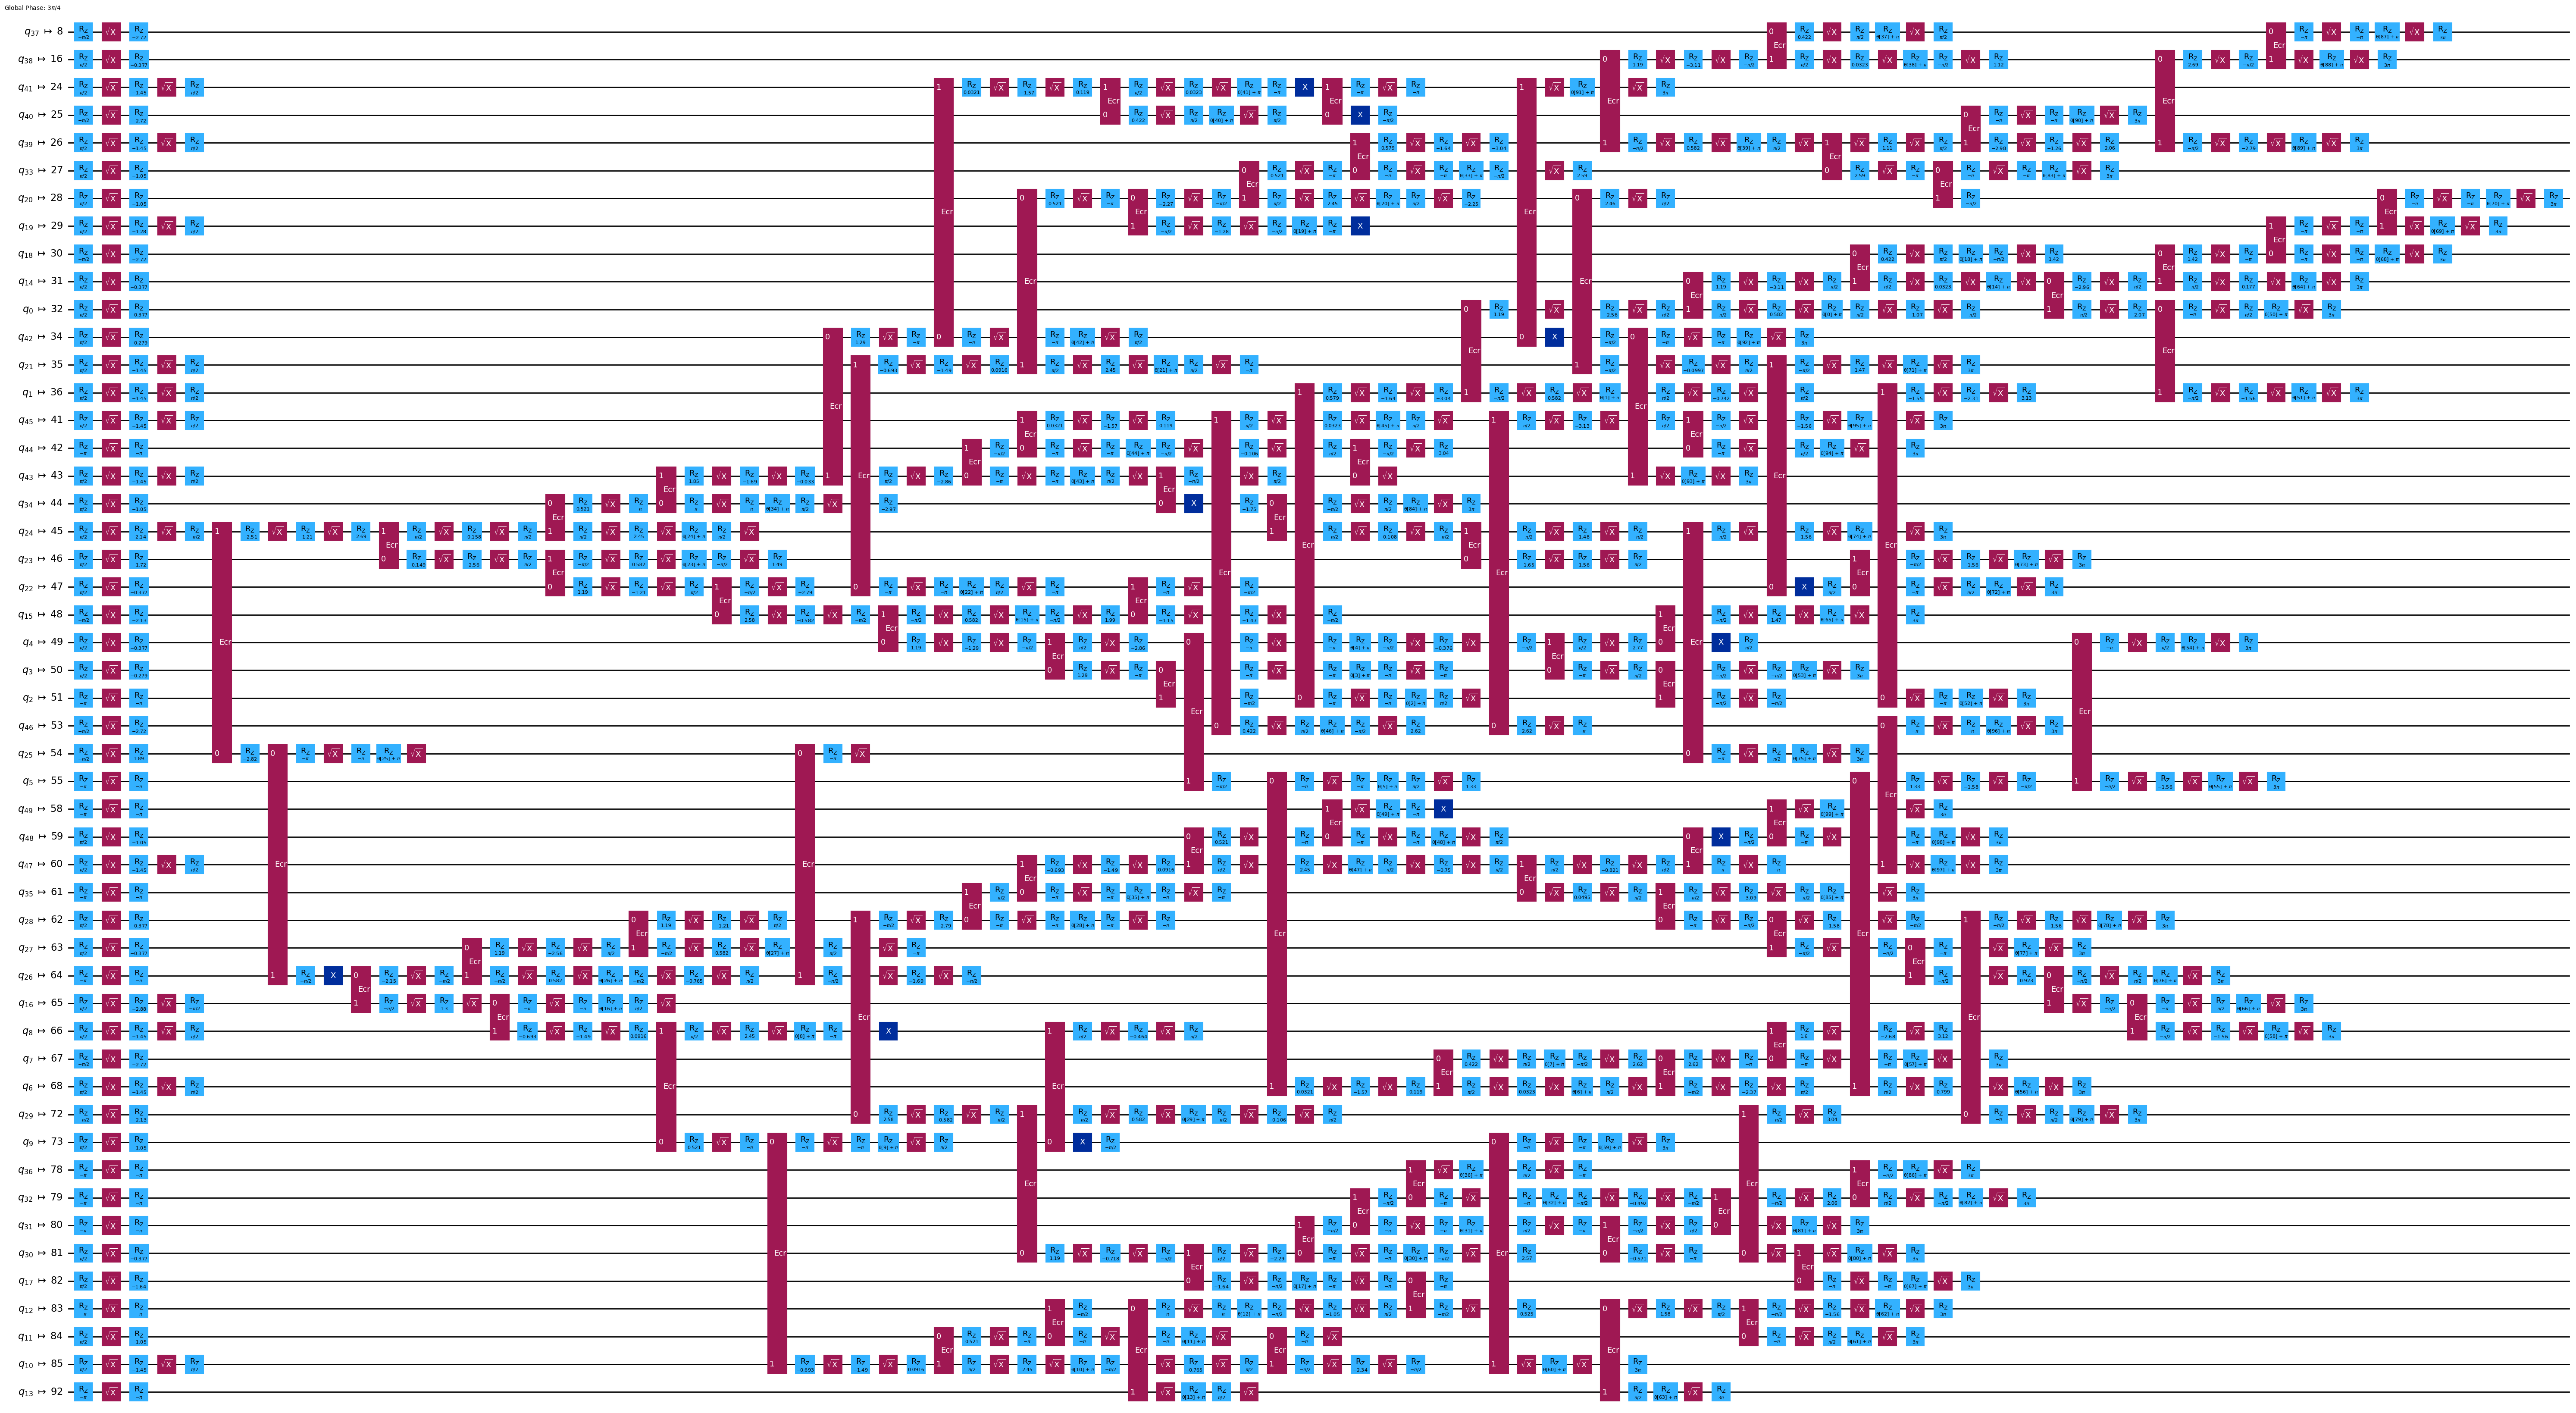

In [ ]:
index_bird = 0 # You can check different birds by changing the index
new_mapping_qc = new_amplitude_embedding(num_qubits, index_bird)
ansatz = generate_ansatz(num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_qc = pm.run(new_mapping_qc.compose(ansatz))
print('Depth new mapping + new ansatz: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
# Submit your answer using following code
grade_lab_bonus_ex2(transpiled_qc) # Expected answer type: QuantumCircuit

Submitting your answer. Please wait...
Transpiled circuit two-qubit depth: 15 < 15 (threshold).
Congratulations! 🎉 Your answer is correct.


## Step 3: Check the optimal parameters using the `AerSimulator`

Now we need to generalize the optimal parameters for a 50 qubits VQC.

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** The optimal parameters array should have $\pi$ in the first rotation of `RealAmplitudes` for the qubits that are used to entangle other qubits and zero everywhere else. 

*Hint: The easiest way to do this is to generate a `source_list` which contains all qubits which are used as source for any `CX` operation in the ansatz.*

</div>  

In [73]:
# Generate this to match your ansatz!

# You can check looking at 2 images above, that the controls and targets, match all of the image!
controls = [i[0] for i in compute_size_50_edges(backend)]
targets = [i[1] for i in compute_size_50_edges(backend)]

### POSSIBLE SOURCE LISTS:
# 1) Source list = all the qubits that:
# - are used as a control
# - but not as a target
# You can also check these are all the qubits in the coupling map, that only have dots on them (control), no Xs (targets)!
source_list = list(dict.fromkeys([control for control in controls if control not in targets])) # Add your code here


# 2) All the controls, without discarting the targets!
# source_list = controls 

def generalize_optimal_params(num_qubits, ansatz, source_list):
    """Generate a `list of optimal parameters for N qubits 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        ansatz (QuantumCircuit): Ansatz for our VQC
        source_list (list): List of qubits used as source to entangle other qubits
    
    Returns:
        opt_params (list): List of optimal parameters generated for N qubits
    """
    
    opt_params = np.zeros(ansatz.num_parameters)
    for i in range(ansatz.num_parameters//2):
        if i in source_list:
            opt_params[i] = np.pi

    return opt_params

In [66]:
# To check that all the source_list qubits got a pi, and the rest a 0!
print("PIs: ", source_list)
print("Zeros: ",[i for i in range(50) if i not in source_list])
print("\n")
print(generalize_optimal_params(50, generate_ansatz(50), source_list))

# Bravo, positions work!

PIs:  [16, 22, 30, 33, 34, 47, 4, 8, 17, 21, 28, 34, 40, 0, 4, 8, 12, 23, 27, 31, 33, 42, 46, 3, 7, 11, 18, 22, 25, 30, 39, 44, 48, 1, 6, 9, 17, 18, 22, 27, 38, 43, 47, 1, 8, 11, 15, 19, 25, 28, 32, 37, 44, 49]
Zeros:  [2, 5, 10, 13, 14, 20, 24, 26, 29, 35, 36, 41, 45]


[3.14159265 3.14159265 0.         3.14159265 3.14159265 0.
 3.14159265 3.14159265 3.14159265 3.14159265 0.         3.14159265
 3.14159265 0.         0.         3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 0.         3.14159265 3.14159265 3.14159265
 0.         3.14159265 0.         3.14159265 3.14159265 0.
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 0.
 0.         3.14159265 3.14159265 3.14159265 3.14159265 0.
 3.14159265 3.14159265 3.14159265 0.         3.14159265 3.14159265
 3.14159265 3.14159265 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** Let's recover the `compute_performance` and the `test_shallow_VQC` functions from Lab 4, both to test with the `AerSimulator` and for a `QPU`. Modify the cost function by including a `-1` factor, as the parameters previously calculated are optimized for the inverse of the cost function. 

**Please note:** You need to use the `new_amplitude_embedding` and the `generate_ansatz` functions which you created above

</div>  

In [67]:
def test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): Real backend from IBM Quantum to run the job
    
    Returns:
        job_id (str): Job ID for Quantum job
    """

    ### Write your code below here ###
    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    
    ansatz = generate_ansatz(num_qubits)

    pubs = []
    for bird, label in enumerate(list_labels):
        ### Write your code below here ###
        new_mapping = new_amplitude_embedding(num_qubits, bird)
        new_classifier = new_mapping.compose(ansatz)

        # Transpile classifier
        transpiled_classifier = pm.run(new_classifier)
        
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        
        ### Don't change any code past this line ###
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")

    
    ### Don't change any code past this line ###                         
                        
    return job_id

def retrieve_job(job_id):
    """Retrieve test results from job id
    Parameters: 
        job_id (str): Job ID
    Returns:
        results_test (list): List of test results
        errors_test (list): List of test errors
    """
    
    job = service.job(job_id)
    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(abs(result.data.evs)-1)) #COST FUNCTION HAS A -1 NOW!!!
        errors_test.append(abs(result.data.stds))
        
    return results_test, errors_test

def test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, backend):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): AerSimulator backend to run the job
    
    Returns:
        results_test (list): List of test results
    """
    
    results_test = []
    ### Write your code below here ###
    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    
    ansatz = generate_ansatz(num_qubits)

    for bird, label in enumerate(list_labels):
        ### Write your code below here ###
        new_mapping = new_amplitude_embedding(num_qubits, bird)
        new_classifier = new_mapping.compose(ansatz)

        # Transpile classifier
        transpiled_classifier = pm.run(new_classifier)
        
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        
        ### Don't change any code past this line ###
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        
        job = estimator.run([pub])
        job_id = job.job_id()
        print(f"Job ID: {job_id}")
        print(f"Status: {job.status()}")


     ### Don't change any code past this line ### 
        result = job.result()[0].data.evs
        results_test.append(abs(abs(result)-1)) # COST FUNCTION NOW HAS A -1!!!  
                                           
    return results_test

def compute_performance(result_list, list_labels):
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        performance (float): Performance of the classifier
    """
    ### Write your code below here ###
    performance = (10-np.sum(np.abs(result-label) for result, label in zip(result_list, list_labels)))*10

        
    ### Don't change any code past this line ###                                    
    return performance

Now we are ready to check if everything works using MPS (tensor networks). This is just to check the circuit and not to benchmark it, hence we are not transpiling the circuit nor applying any noise models.

<div class="alert alert-block alert-danger">

**Please note:** Please do not transpile before checking your result in the code below. This is just a check and not a benchmark.

</div>

Job ID: 54c732b2-fd17-4361-ada5-4ec7be98f589
Status: JobStatus.RUNNING
Job ID: c249b7ed-6a7c-4502-a719-614ad906ab28
Status: JobStatus.RUNNING
Job ID: c6d48b5f-bb50-4d54-b393-21cdea738a00
Status: JobStatus.RUNNING
Job ID: ae9041b5-46de-4367-9bbf-9031d3e2784a
Status: JobStatus.RUNNING
Job ID: 2a60afa8-699e-4326-99b4-34d1c156bde2
Status: JobStatus.RUNNING
Job ID: 6c371085-929e-4223-9359-149ebb084f0e
Status: JobStatus.RUNNING
Job ID: 24246b14-c553-469b-b410-b29425e9cc2e
Status: JobStatus.RUNNING
Job ID: adeae810-c294-44aa-a4d3-aea1958c87e6
Status: JobStatus.RUNNING
Job ID: d3318c07-e897-4f39-b154-cbb4746fb2cb
Status: JobStatus.RUNNING
Job ID: 006cba92-fc4c-4214-b626-f83c327aede9
Status: JobStatus.RUNNING
Performance for resilience 0: 99.365234375


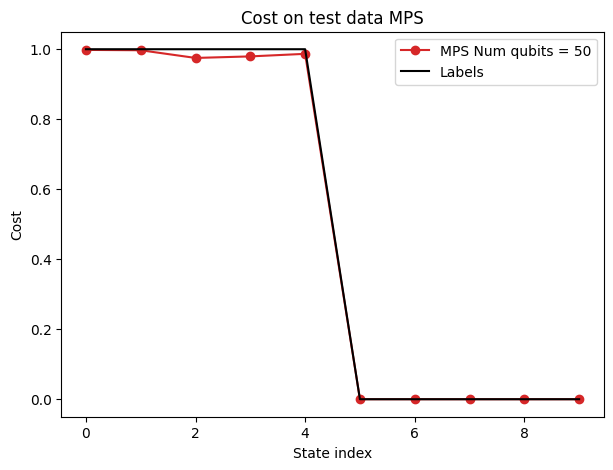

In [68]:
num_qubits = 50

aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(new_mapping_qc)

list_labels = np.append(np.ones(5), np.zeros(5))
obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, generate_ansatz(num_qubits), source_list)
options = EstimatorOptions()

results_test_aer_sim = test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, aer_sim)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data MPS')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
print(f"Performance for resilience 0: {compute_performance(results_test_aer_sim, list_labels)}")
ax.plot(results_test_aer_sim, 'o-', color='tab:red', label='MPS Num qubits = ' + str(num_qubits))
ax.plot(list_labels, 'k-', label='Labels')
ax.legend()

In [ ]:
# Submit your answer using following code
grade_lab_bonus_ex3(results_test_aer_sim) # Expected variable types: List

Submitting your answer. Please wait...
Performance: 99.42% > 90% (threshold).
Congratulations! 🎉 Your answer is correct.


## Final step: Testing a 50 qubit VQC on a quantum device (!)

At this point, you should be all set to run your VQC on a real device!  Lets start by choosing our device. For this part of the Lab, we recommend choosing an IBM Quantum backend that you have access to, since we will use these simulations as a guide to run the code on the real backend later on. Take into account that the properties of the devices can change a lot from one to another, so testing the VQC might not work so well for certain devices. We have used [ibm_sherbrooke](https://quantum.ibm.com/services/resources?system=ibm_sherbrooke). 

You can find the list of systems you have access to on [the Systems tab](https://quantum.ibm.com/services/resources?resourceType=current-instance&order=queue%20ASC&view=table) on IBM Quantum platform or run the following code:

```python
    from qiskit_ibm_runtime import QiskitRuntimeService

    service = QiskitRuntimeService()
    # list all available systems
    service.backends()
    # get the least busy system
    backend = service.least_busy()
```


<div class="alert alert-block alert-danger">

**Please note:** Please perform the checks above before running it on the real device to ensure you make the best use of your QPU time.

</div>

In [59]:
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

Let us specify options for our real system run. You can review the explainations on `options` from [Lab 4](https://github.com/qiskit-community/ibm-quantum-challenge-2024/blob/main/content/lab_bonus/lab-bonus.ipynb#Zero-Noise-Extrapolation-(ZNE))

More detais about how to configure `options` for error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).




<div class="alert alert-block alert-danger">

**Please note:** For `10000` shots the estimated runtime is around 4 min and for `5000` it will be around 2 minutes. Please be mindful of the QPU time limitation you have on your account
</div>

In [60]:
# RUN JOBS
num_qubits = 50
obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, generate_ansatz(num_qubits), source_list)

# NO ZNE mitigation
for optimization_level in [0,1]: # For ZNE mitigation
    DD = True
    options = EstimatorOptions(default_shots = 10_000, 
                            optimization_level=optimization_level, 
                            resilience_level=2)  
    options.dynamical_decoupling.enable = DD
    options.dynamical_decoupling.sequence_type = 'XpXm'

    job_id = test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend)

# With ZNE mitigation
for optimization_level in [0,1]: # For ZNE mitigation

    DD = True
    options = EstimatorOptions(default_shots = 10_000, 
                            optimization_level=optimization_level, 
                            resilience_level=2)  
    options.dynamical_decoupling.enable = DD
    options.dynamical_decoupling.sequence_type = 'XpXm'

    # OPTIONAL
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = (1, 1.2, 1.4)
    options.resilience.zne.extrapolator = ('exponential', 'linear', 'polynomial_degree_2') #order matters

    job_id = test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend)
    

Job ID: csp9s1mp1vzg008adw8g
Status: QUEUED
Job ID: csp9s8x1k2e0008p82d0
Status: QUEUED
Job ID: csp9sm60c2pg008c3vpg
Status: QUEUED
Job ID: csp9sxqvnxy0008dfcq0
Status: QUEUED


## ALL 10 EXECUTIONS PLOTS IN THE NEXT CELLS!
### The best results was **9)**!

### 1) plot on kyoto (no ZNE, shots=10k)

Performance for no DD + no TREX: 49.936
Performance for DD + TREX: 54.147


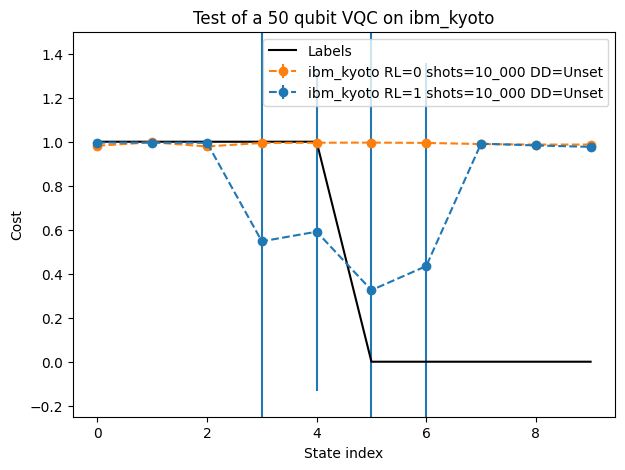

In [87]:
results_test_0_DD, errors_test_0_DD = retrieve_job('csn955cvwqp0008b1gh0') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csn95m61k2e0008p4z70') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.25, 1.5))

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots=10_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots=10_000 DD={options.dynamical_decoupling.enable}')

ax.plot(list_labels, 'k-', label='Labels')


ax.legend() 

### 2) plot, on sherbrooke (w/ ZNE, shots=10k)

Performance for no DD + no TREX + no ZNE: 53.852
Performance for DD + TREX + ZNE: -21456711916591308565643264.000


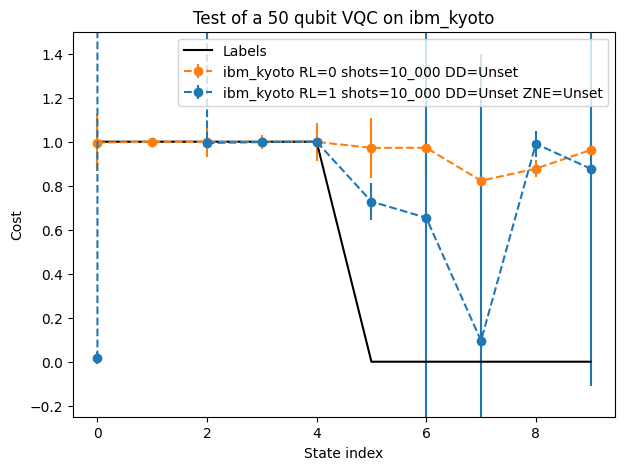

In [88]:
results_test_0_DD_ZNE, errors_test_0_DD_ZNE = retrieve_job('csn991w1k2e0008p4zd0')
results_test_1_DD_ZNE, errors_test_1_DD_ZNE = retrieve_job('csn99hy1k2e0008p4zeg') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.25, 1.5))

print(f"Performance for no DD + no TREX + no ZNE: {compute_performance(results_test_0_DD_ZNE, list_labels):.3f}")
print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_1_DD_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD_ZNE, fmt='--o', yerr=errors_test_0_DD_ZNE, color='tab:orange', label=f'{backend.name} RL=0 shots=10_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD_ZNE, fmt='--o',  yerr=errors_test_1_DD_ZNE, color='tab:blue', label=f'{backend.name} RL=1 shots=10_000 DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

### 3) Plot, on kyoto (no ZNE & ZNE, shots=5k)

Performance for no DD + no TREX: 50.048
Performance for DD + TREX: 43.171
Performance for DD + TREX + ZNE: -249806662312417779198722048.000


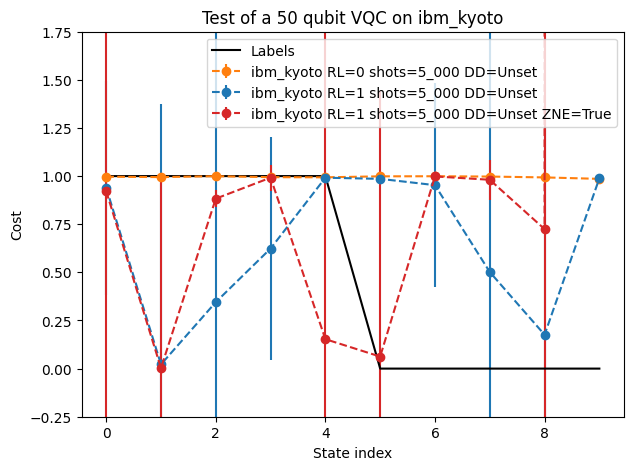

In [89]:
results_test_0_DD, errors_test_0_DD = retrieve_job('csnejkj1k2e0008p5g20') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csnejqtp1vzg008ab3k0') 
results_test_1_DD_ZNE, errors_test_1_DD_ZNE = retrieve_job('csnejvvea560008ff950') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.25, 1.75))

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_1_DD_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots=5_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots=5_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD_ZNE, fmt='--o', yerr=errors_test_1_DD_ZNE, color='tab:red',label=f'{backend.name} RL=1 shots=5_000 DD={options.dynamical_decoupling.enable} ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

### 4) First plot on premium user (ibm_kyoto, shots=10k I think)

Performance for no DD + no TREX: 50.660
Performance for DD + TREX: 59.004
Performance for no DD + no TREX + no ZNE: 60.009
Performance for DD + TREX + ZNE: -157248297798706649932759040.000


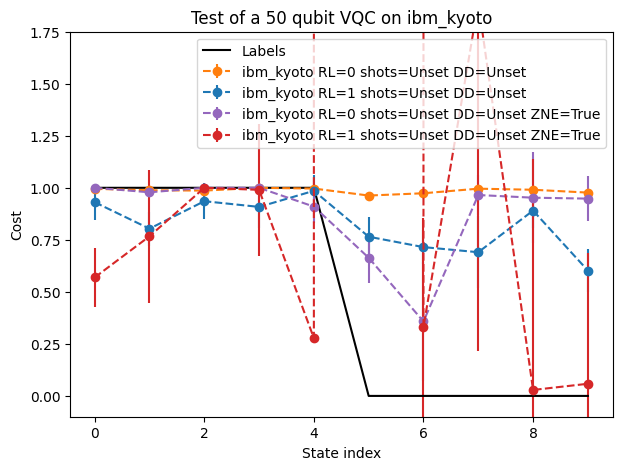

In [83]:
results_test_0_DD, errors_test_0_DD = retrieve_job('csnecrvvwqp0008b21rg') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csnecx3vwqp0008b21v0') 
results_test_0_DD_ZNE, errors_test_0_DD_ZNE = retrieve_job('csned1mvwqp0008b21vg')
results_test_1_DD_ZNE, errors_test_1_DD_ZNE = retrieve_job('csned6cvnxy0008dcqwg') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.1, 1.75))

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")

print(f"Performance for no DD + no TREX + no ZNE: {compute_performance(results_test_0_DD_ZNE, list_labels):.3f}")
print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_1_DD_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')

ax.errorbar(range(10), results_test_0_DD_ZNE, fmt='--o',  yerr=errors_test_0_DD_ZNE, color='tab:purple', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE=True')
ax.errorbar(range(10), results_test_1_DD_ZNE, fmt='--o', yerr=errors_test_1_DD_ZNE, color='tab:red',label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

### 5) Second plot on premium user (ibm_kyoto, shots=5&10k, noise_factor=[1, 1.2, 1.4])

Performance for no DD + no TREX: 50.152
Performance for DD + TREX: 63.054
Performance for DD + TREX + ZNE: 58.626


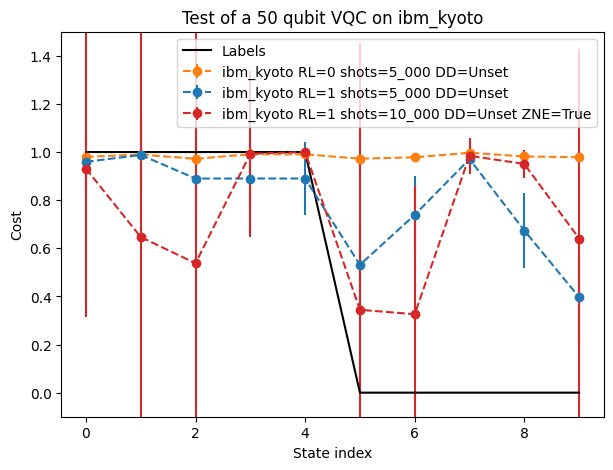

In [81]:
results_test_0_DD, errors_test_0_DD = retrieve_job('csnhdnyvwqp0008b2b8g') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csnhdsqea560008ffhkg') 
results_test_1_DD_ZNE, errors_test_1_DD_ZNE = retrieve_job('csnhdxqea560008ffhm0') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.1, 1.5))

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_1_DD_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots=5_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots=5_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD_ZNE, fmt='--o', yerr=errors_test_1_DD_ZNE, color='tab:red',label=f'{backend.name} RL=1 shots=10_000 DD={options.dynamical_decoupling.enable} ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend()

### 6) Almost last plot on premium user (ibm_kyoto, shots=10k, noise_factor=[1, 1.2, 1.4])

Performance for no DD + no TREX: 50.184
Performance for DD + TREX: 62.108
Performance for DD + TREX + ZNE: 57.807


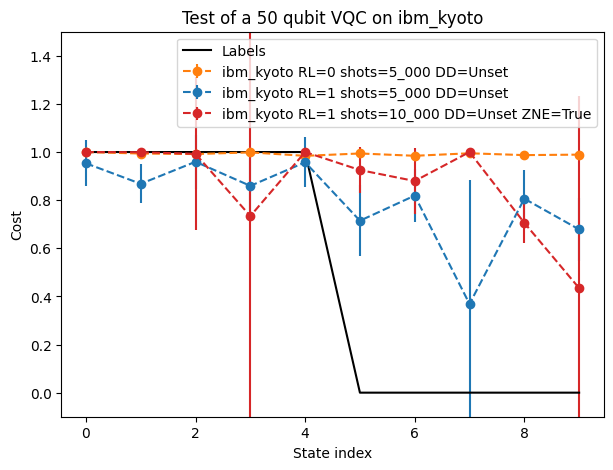

In [80]:
results_test_0_DD, errors_test_0_DD = retrieve_job('csnj9bd0c2pg008c1d1g') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csnj9f5vnxy0008dd2vg') 
results_test_1_DD_ZNE, errors_test_1_DD_ZNE = retrieve_job('csnj9jy0c2pg008c1d2g') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.1, 1.5))

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_1_DD_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots=5_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots=5_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD_ZNE, fmt='--o', yerr=errors_test_1_DD_ZNE, color='tab:red',label=f'{backend.name} RL=1 shots=10_000 DD={options.dynamical_decoupling.enable} ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend()

### 7) Last plot on premium user (ibm_kyoto, shots=10k, noise_factor=[1, 1.2, 1.4]) <--> with backend old set

Performance for no DD + no TREX: 50.420
Performance for DD + TREX: 58.103


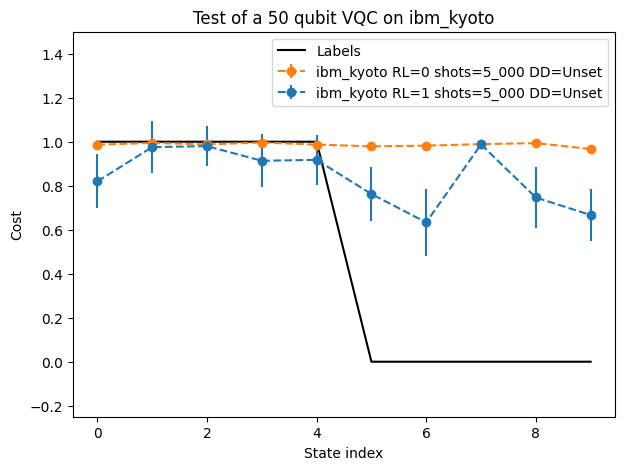

In [90]:
results_test_0_DD, errors_test_0_DD = retrieve_job('csnjyxkea560008ffpng') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csnjz240c2pg008c1ej0') 
results_test_1_DD_ZNE, errors_test_1_DD_ZNE = retrieve_job('csnjz5wvnxy0008dd4fg') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.25, 1.5))

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
# print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_1_DD_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots=5_000 DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots=5_000 DD={options.dynamical_decoupling.enable}')
# ax.errorbar(range(10), results_test_1_DD_ZNE, fmt='--o', yerr=errors_test_1_DD_ZNE, color='tab:red',label=f'{backend.name} RL=1 shots=10_000 DD={options.dynamical_decoupling.enable} ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend()

### 8) BEST RESULT! (RL 2, 10k shots, opt=0/1)

Performance r2 for opt0: 69.673
Performance r2 for op1: 65.546
Performance r2 for opt1 + ZNE: 60.415


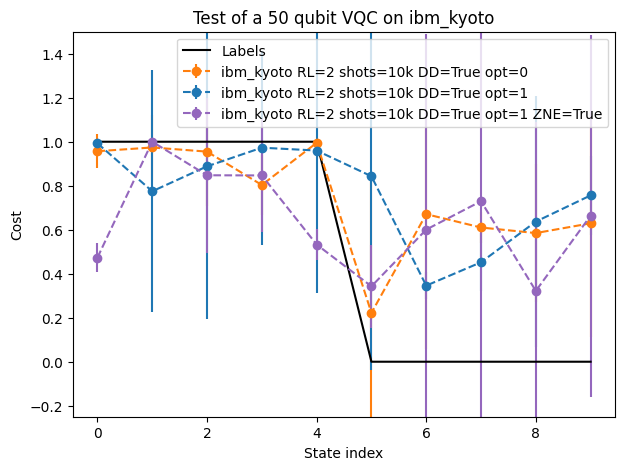

In [ ]:
results_test_r2_DD_opt0, errors_test_r2_DD_opt0 = retrieve_job('csp1hwzp1vzg008ad9z0') 
results_test_r2_DD_opt1, errors_test_r2_DD_opt1 = retrieve_job('csp1j00vnxy0008det1g') 
results_test_r2_DD_opt0_ZNE, errors_test_r2_DD_opt0_ZNE = retrieve_job('csp1j38p1vzg008ada00') 
results_test_r2_DD_opt1_ZNE, errors_test_r2_DD_opt1_ZNE = retrieve_job('csp1j6gvnxy0008det30')

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.25,1.5))

print(f"Performance r2 for opt0: {compute_performance(results_test_r2_DD_opt0, list_labels):.3f}")
print(f"Performance r2 for op1: {compute_performance(results_test_r2_DD_opt1, list_labels):.3f}")
# print(f"Performance r2 for opt0 + ZNE: {compute_performance(results_test_r2_DD_opt0_ZNE, list_labels):.3f}")
print(f"Performance r2 for opt1 + ZNE: {compute_performance(results_test_r2_DD_opt1_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_r2_DD_opt0, fmt='--o', yerr=errors_test_r2_DD_opt0, color='tab:orange', label=f'{backend.name} RL=2 shots=10k DD=True opt=0')
ax.errorbar(range(10), results_test_r2_DD_opt1, fmt='--o',  yerr=errors_test_r2_DD_opt1, color='tab:blue', label=f'{backend.name} RL=2 shots=10k DD=True opt=1')
# ax.errorbar(range(10), results_test_r2_DD_opt0_ZNE, fmt='--o', yerr=errors_test_r2_DD_opt0_ZNE, color='tab:red',label=f'{backend.name} RL=2 shots=10k DD=True opt=0 ZNE=True')
ax.errorbar(range(10), results_test_r2_DD_opt1_ZNE, fmt='--o', yerr=errors_test_r2_DD_opt1_ZNE, color='tab:purple',label=f'{backend.name} RL=2 shots=10k DD=True opt=1 ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend()

### 9) Another one later, decent asweel (RL2, 10k shots, two opt)  <--> with full kyoto mapping - ex3 not working

Performance r2 for opt0: 65.362
Performance r2 for op1: 59.859


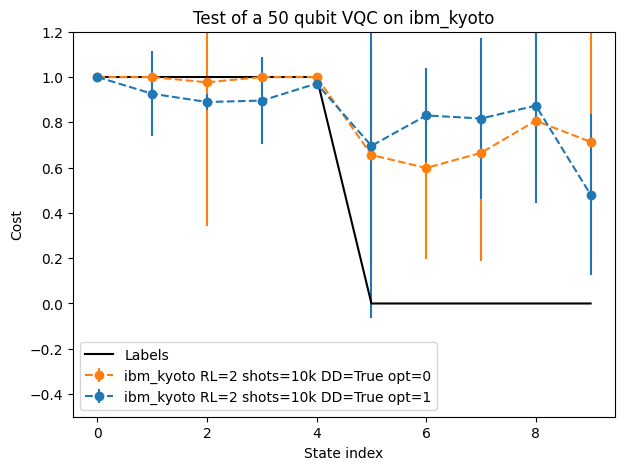

In [78]:
results_test_r2_DD_opt0, errors_test_r2_DD_opt0 = retrieve_job('csp3m89p1vzg008adfv0') 
results_test_r2_DD_opt1, errors_test_r2_DD_opt1 = retrieve_job('csp3mehvnxy0008deyx0') 
results_test_r2_DD_opt0_ZNE, errors_test_r2_DD_opt0_ZNE = retrieve_job('csp3mnavwqp0008b47gg') 
results_test_r2_DD_opt1_ZNE, errors_test_r2_DD_opt1_ZNE = retrieve_job('csp3mvkp1vzg008adfw0')

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.5,1.2))

print(f"Performance r2 for opt0: {compute_performance(results_test_r2_DD_opt0, list_labels):.3f}")
print(f"Performance r2 for op1: {compute_performance(results_test_r2_DD_opt1, list_labels):.3f}")
# print(f"Performance r2 for opt0 + ZNE: {compute_performance(results_test_r2_DD_opt0_ZNE, list_labels):.3f}")
# print(f"Performance r2 for opt1 + ZNE: {compute_performance(results_test_r2_DD_opt1_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_r2_DD_opt0, fmt='--o', yerr=errors_test_r2_DD_opt0, color='tab:orange', label=f'{backend.name} RL=2 shots=10k DD=True opt=0')
ax.errorbar(range(10), results_test_r2_DD_opt1, fmt='--o',  yerr=errors_test_r2_DD_opt1, color='tab:blue', label=f'{backend.name} RL=2 shots=10k DD=True opt=1')
# ax.errorbar(range(10), results_test_r2_DD_opt0_ZNE, fmt='--o', yerr=errors_test_r2_DD_opt0_ZNE, color='tab:red',label=f'{backend.name} RL=2 shots=10k DD=True opt=0 ZNE=True')
# ax.errorbar(range(10), results_test_r2_DD_opt1_ZNE, fmt='--o', yerr=errors_test_r2_DD_opt1_ZNE, color='tab:purple',label=f'{backend.name} RL=2 shots=10k DD=True opt=1 ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend()

### 10) Tenth and final executions!

Performance r2 for opt0: 55.964
Performance r2 for op1: 53.201
Performance r2 for opt0 + ZNE: -825248826335197777935466496.000
Performance r2 for opt1 + ZNE: 63.931


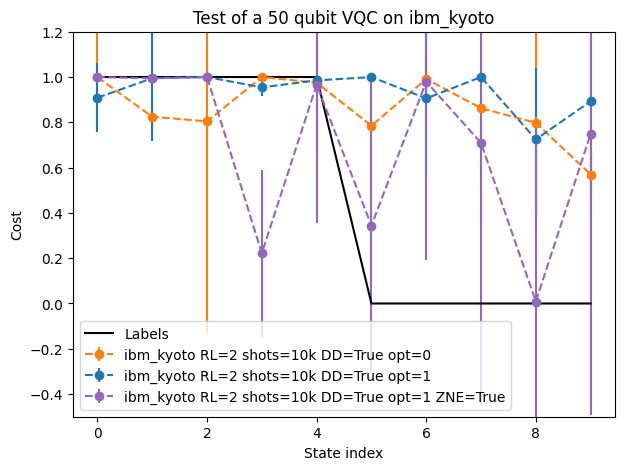

In [77]:
results_test_r2_DD_opt0, errors_test_r2_DD_opt0 = retrieve_job('csp9s1mp1vzg008adw8g') 
results_test_r2_DD_opt1, errors_test_r2_DD_opt1 = retrieve_job('csp9s8x1k2e0008p82d0') 
results_test_r2_DD_opt0_ZNE, errors_test_r2_DD_opt0_ZNE = retrieve_job('csp9sm60c2pg008c3vpg') 
results_test_r2_DD_opt1_ZNE, errors_test_r2_DD_opt1_ZNE = retrieve_job('csp9sxqvnxy0008dfcq0')

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

plt.ylim((-0.5,1.2))

print(f"Performance r2 for opt0: {compute_performance(results_test_r2_DD_opt0, list_labels):.3f}")
print(f"Performance r2 for op1: {compute_performance(results_test_r2_DD_opt1, list_labels):.3f}")
print(f"Performance r2 for opt0 + ZNE: {compute_performance(results_test_r2_DD_opt0_ZNE, list_labels):.3f}")
print(f"Performance r2 for opt1 + ZNE: {compute_performance(results_test_r2_DD_opt1_ZNE, list_labels):.3f}")

ax.errorbar(range(10), results_test_r2_DD_opt0, fmt='--o', yerr=errors_test_r2_DD_opt0, color='tab:orange', label=f'{backend.name} RL=2 shots=10k DD=True opt=0')
ax.errorbar(range(10), results_test_r2_DD_opt1, fmt='--o',  yerr=errors_test_r2_DD_opt1, color='tab:blue', label=f'{backend.name} RL=2 shots=10k DD=True opt=1')
# ax.errorbar(range(10), results_test_r2_DD_opt0_ZNE, fmt='--o', yerr=errors_test_r2_DD_opt0_ZNE, color='tab:red',label=f'{backend.name} RL=2 shots=10k DD=True opt=0 ZNE=True')
ax.errorbar(range(10), results_test_r2_DD_opt1_ZNE, fmt='--o', yerr=errors_test_r2_DD_opt1_ZNE, color='tab:purple',label=f'{backend.name} RL=2 shots=10k DD=True opt=1 ZNE=True')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend()

### Original ploting function:

In [ ]:
results_test_0_DD, errors_test_0_DD = retrieve_job('job_id_HERE') 
results_test_1_DD, errors_test_1_DD = retrieve_job('job_id_HERE')

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")

ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')

ax.plot(list_labels, 'k-', label='Labels')


ax.legend() 

##### Your results should look similar to the ones below. This is a previous job run using `ibm_kyiv`

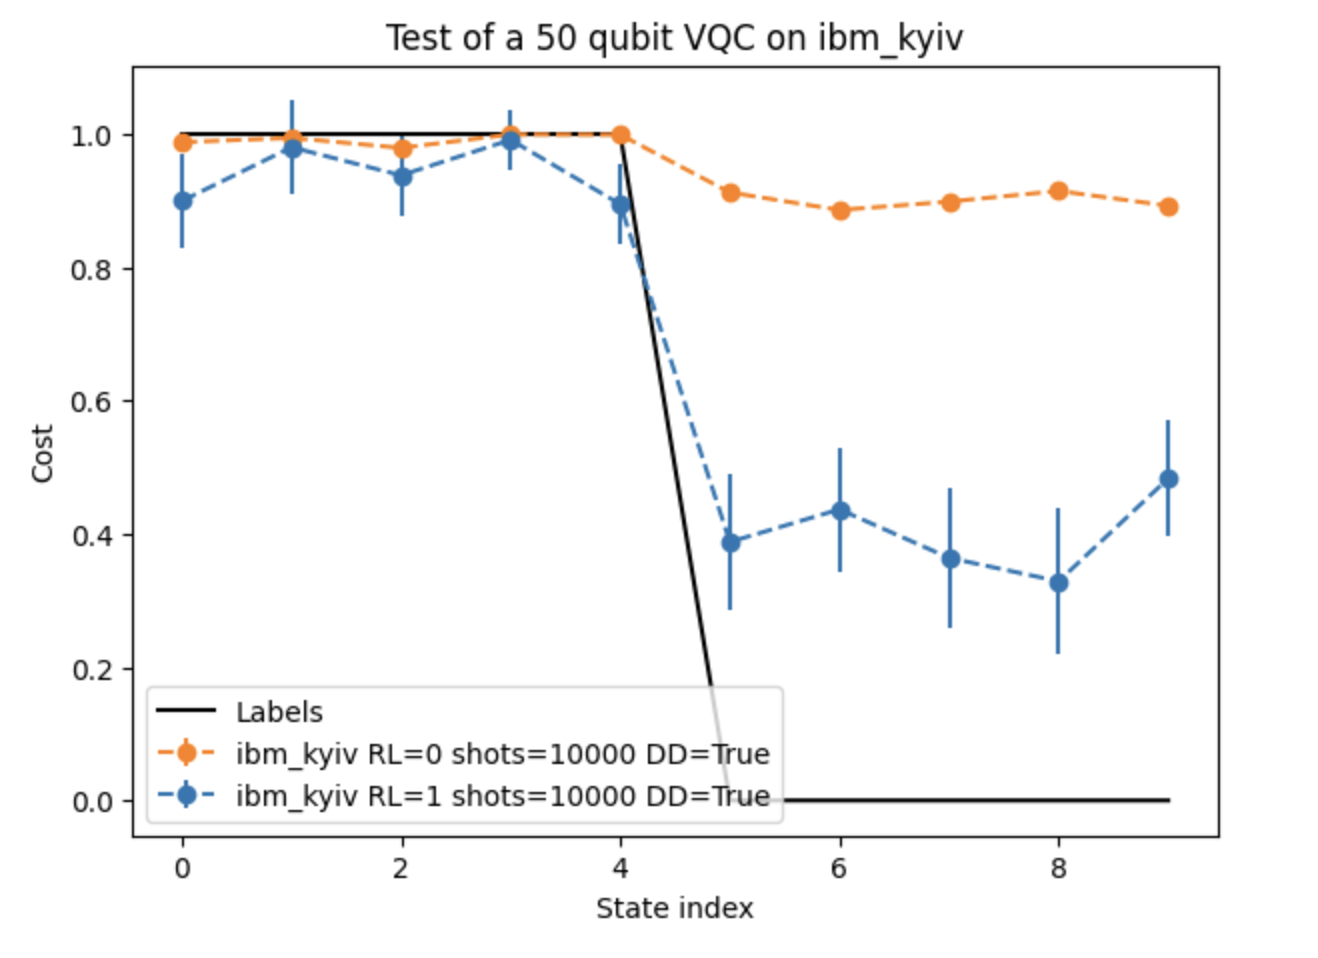

# Additional information

**Created by:** Joana Fraxanet, Marcel Pfaffhauser, Junye Huang, Vishal Sharathchandra Bajpe

**Advised by:** Pedro Rivero

**Version:** 1.0.0